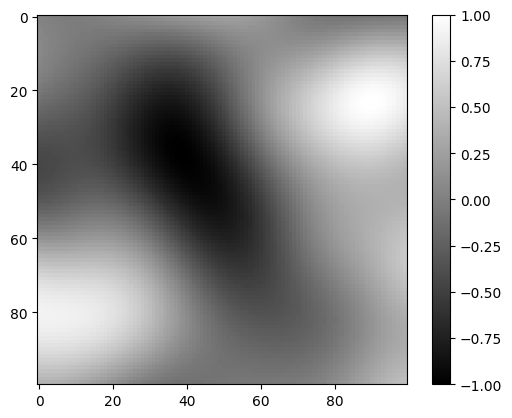

In [15]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Define image size (e.g., 28x28 for MNIST-like images)
image_size = 100
x = np.linspace(0, 1, image_size)
y = np.linspace(0, 1, image_size)
X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T  # Coordinates for each pixel

# Define the kernel for smoothness
length_scale = 0.2  # Adjust for desired smoothness
kernel = RBF(length_scale=length_scale)

# Sample from a Gaussian Process
gp = GaussianProcessRegressor(kernel=kernel)
intensity_samples = gp.sample_y(coords, n_samples=1, random_state=0).reshape(image_size, image_size)

# Normalize intensity to [0, 255] for a grayscale image
# intensity_samples = 255 * (intensity_samples - intensity_samples.min()) / (intensity_samples.max() - intensity_samples.min())
intensity_samples = (intensity_samples - intensity_samples.min()) / (intensity_samples.max() - intensity_samples.min())
intensity_samples = 2 * intensity_samples - 1
# Visualize the simulated image
import matplotlib.pyplot as plt
plt.imshow(intensity_samples, cmap="gray")
plt.colorbar()
plt.show()

In [ ]:
### Start from here

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm


In [18]:
N = [100, 500, 1000] # sample sizes: 100, 500, 1000
D = ['Poisson', 'Homo_Gamma', 'Hetero_Gaussian'] # true distribution

We consider the following generic semi-structured predictor $\eta_k$:

$$\eta_k = \beta_k + \alpha_{k,1} X_1 + \alpha_{k,2} X_2 + f_{k,1}(Z_1) + f_{k,2}(Z_2) + \text{d}(U),$$

where:
- $\tilde{X}_1, \tilde{X}_2 \sim \mathcal{N}(0, 1)$ are structured covariates for linear effects, and $\tilde{\alpha}_{1,1}, \tilde{\alpha}_{1,2}, \tilde{\alpha}_{2,1}$ and $\tilde{\alpha}_{2,2}$ are set to be 3, -1, -0.5 and 6 respectively. $X_1$ and $X_2$ are scaled from $\tilde{X}_1$ and $\tilde{X}_2$ into the range of $[0,1]$. Moreover, the linear effects for $\eta_k$ are scaled from $\sum_{i=1}^{2} \tilde{\alpha}_{k,i}\tilde{X}_i$ into $\sum_{i=1}^{2} \alpha_{k,i}X_i$ so that the scale of all effects is within the same range $[-1,1]$.

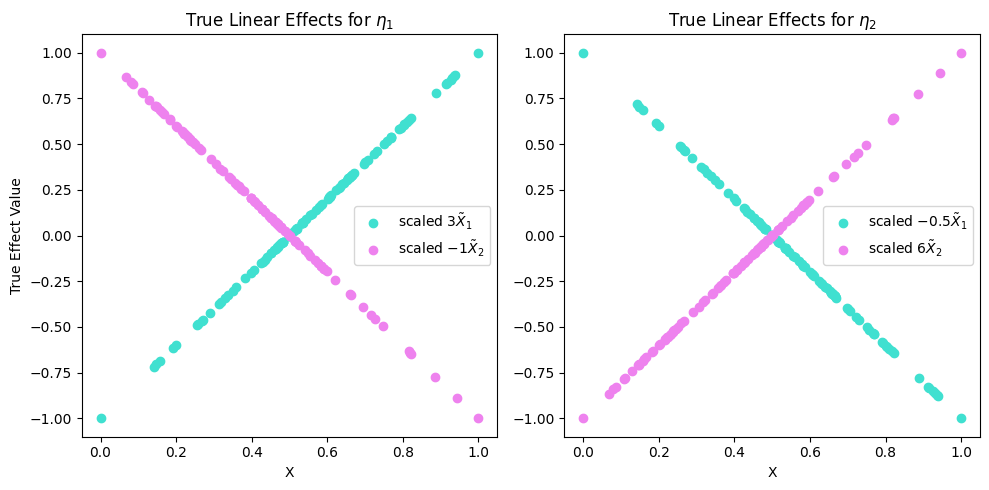

In [55]:

# 1. Structured Linear Effects
n = N[0]  # Adjust as needed
np.random.seed(42)
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
X1_scaled = (X1-min(X1))/(max(X1)-min(X1))
X2_scaled = (X2-min(X2))/(max(X2)-min(X2))


alpha_11, alpha_12, alpha_21, alpha_22 = 3, -1, -0.5, 6
linear_effect_11 = alpha_11 * X1_scaled
linear_effect_12 = alpha_12 * X2_scaled
linear_effect_21 = alpha_21 * X1_scaled
linear_effect_22 = alpha_22 * X2_scaled
linear_effect_11_scaled = 2 * (linear_effect_11-min(linear_effect_11))/(max(linear_effect_11)-min(linear_effect_11)) - 1
linear_effect_12_scaled = 2 * (linear_effect_12-min(linear_effect_12))/(max(linear_effect_12)-min(linear_effect_12)) - 1
linear_effect_21_scaled = 2 * (linear_effect_21-min(linear_effect_21))/(max(linear_effect_21)-min(linear_effect_21)) - 1
linear_effect_22_scaled = 2 * (linear_effect_22-min(linear_effect_22))/(max(linear_effect_22)-min(linear_effect_22)) - 1

# Plot linear effect
# plt.figure(figsize=(10, 6))
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(X1_scaled, linear_effect_11_scaled, 'o', label='scaled $3 \\tilde{X}_1$', color="turquoise")
ax1.plot(X2_scaled, linear_effect_12_scaled, 'o', label='scaled $-1 \\tilde{X}_2$', color="violet")
ax1.set_title("True Linear Effects for $\\eta_1$")
ax1.set_xlabel("X")
ax1.set_ylabel("True Effect Value")
ax1.legend()

ax2.plot(X1_scaled, linear_effect_21_scaled, 'o', label='scaled $-0.5 \\tilde{X}_1$', color="turquoise")
ax2.plot(X2_scaled, linear_effect_22_scaled, 'o', label='scaled $6 \\tilde{X}_2$', color="violet")
ax2.set_title("True Linear Effects for $\\eta_2$")
ax2.set_xlabel("X")
# ax2.set_ylabel("True Effect Value")
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()


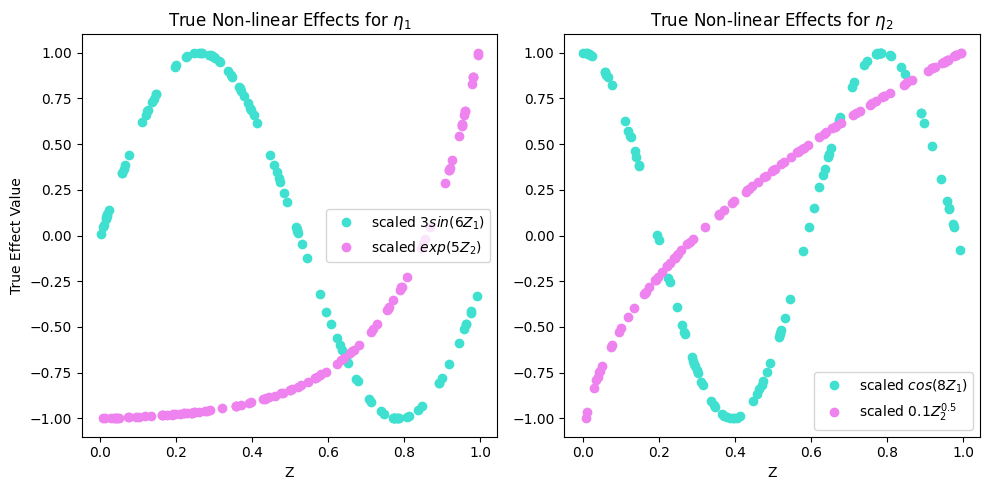

In [68]:

# 2. Structured Non-linear Effects
Z1 = np.random.uniform(0, 1, n)
Z2 = np.random.uniform(0, 1, n)

nonlinear_effect_11 = 3 * np.sin(6 * Z1)
nonlinear_effect_12 = np.exp(5 * Z2)
nonlinear_effect_21 = np.cos(8 * Z1)
nonlinear_effect_22 = 0.1*Z2**0.5
nonlinear_effect_11_scaled = 2 * (nonlinear_effect_11-min(nonlinear_effect_11))/(max(nonlinear_effect_11)-min(nonlinear_effect_11)) - 1
nonlinear_effect_12_scaled = 2 * (nonlinear_effect_12-min(nonlinear_effect_12))/(max(nonlinear_effect_12)-min(nonlinear_effect_12)) - 1
nonlinear_effect_21_scaled = 2 * (nonlinear_effect_21-min(nonlinear_effect_21))/(max(nonlinear_effect_21)-min(nonlinear_effect_21)) - 1
nonlinear_effect_22_scaled = 2 * (nonlinear_effect_22-min(nonlinear_effect_22))/(max(nonlinear_effect_22)-min(nonlinear_effect_22)) - 1

# Plot non-linear effects
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(Z1, nonlinear_effect_11_scaled, 'o', label='scaled $3 sin(6 Z_1)$', color="turquoise")
ax1.plot(Z2, nonlinear_effect_12_scaled, 'o', label='scaled $exp(5 Z_2)$', color="violet")
ax1.set_title("True Non-linear Effects for $\\eta_1$")
ax1.set_xlabel("Z")
ax1.set_ylabel("True Effect Value")
ax1.legend()

ax2.plot(Z1, nonlinear_effect_21_scaled, 'o', label='scaled $cos(8 Z_1)$', color="turquoise")
ax2.plot(Z2, nonlinear_effect_22_scaled, 'o', label='scaled $0.1 Z_2^{0.5}$', color="violet")
ax2.set_title("True Non-linear Effects for $\\eta_2$")
ax2.set_xlabel("Z")
# ax2.set_ylabel("True Effect Value")
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()


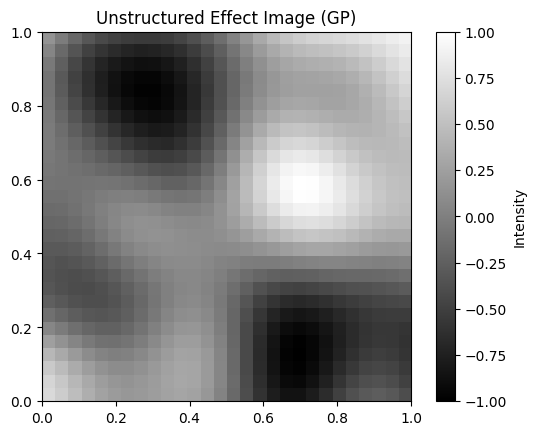

In [73]:

# 3. Unstructured Effect (Image using GP)
image_size = 28
x = np.linspace(0, 1, image_size)
y = np.linspace(0, 1, image_size)
X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T

# Define the GP kernel and create a GP
length_scale = 0.2
kernel = RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel)

# Sample intensity values from the GP
intensity_samples = gp.sample_y(coords, n_samples=1, random_state=0).reshape(image_size, image_size)

# Scale to [-1,1]
intensity_samples = 2 * (intensity_samples - intensity_samples.min()) / (intensity_samples.max() - intensity_samples.min()) - 1

# Plot unstructured effect (GP image)
plt.figure()
plt.imshow(intensity_samples, cmap="gray", extent=(0, 1, 0, 1))
plt.colorbar(label="Intensity")
plt.title("Unstructured Effect Image (GP)")
plt.show()


In [77]:
# import numpy as np
# import noise  # Install with `pip install noise`
# import matplotlib.pyplot as plt

# def generate_perlin_image(size=28, octaves=4, persistence=0.5, lacunarity=2.0):
#     image = np.zeros((size, size))
#     scale = 5.0  # Controls the "zoom" level of the noise

#     # Normalize coordinates to [0, 1]
#     for i in range(size):
#         for j in range(size):
#             x, y = i / (size - 1), j / (size - 1)  # Normalized to [0, 1]
#             image[i][j] = noise.pnoise2(x * scale, y * scale, octaves=octaves, persistence=persistence, lacunarity=lacunarity, repeatx=size, repeaty=size, base=42)
    
#     # Normalize the image values to [-1, 1] range
#     image = 2 * (image - np.min(image)) / (np.max(image) - np.min(image)) - 1
#     return image

# # Generate and display the image
# perlin_image = generate_perlin_image()
# plt.imshow(perlin_image, cmap='gray', extent=[0, 1, 0, 1])
# plt.colorbar()
# plt.title("Simulated Image Using Perlin Noise with Normalized Coordinates")
# plt.xlabel("Normalized X (0 to 1)")
# plt.ylabel("Normalized Y (0 to 1)")
# plt.show()

In [ ]:

# 4. Coverage Rate Calculation Example (for linear effect alpha_1)
# Assuming alpha_hat and its CI for each replication are obtained through some estimation method

# Placeholder example data
R = 100  # Number of replications
true_alpha_1 = 3
alpha_hat_samples = np.random.normal(loc=true_alpha_1, scale=0.5, size=R)  # Simulated estimated alpha values
alpha_CI_low = alpha_hat_samples - 1.96 * 0.5  # 95% CI lower bound
alpha_CI_high = alpha_hat_samples + 1.96 * 0.5  # 95% CI upper bound

# Compute coverage rate
coverage_rate_alpha_1 = np.mean((true_alpha_1 >= alpha_CI_low) & (true_alpha_1 <= alpha_CI_high))
print(f"Coverage Rate for Linear Effect α₁: {coverage_rate_alpha_1:.2f}")

# Repeat similar coverage rate calculations for other effects based on their respective confidence intervals

Parallel Simulation for Coverage Rate Computation

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.stats import poisson, gamma, norm
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt

# Helper functions for scaling
def scale_to_range(data, lower=0, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

# Define Gaussian Process Kernel
def rbf_kernel(x1, x2, sigma=1.0, length_scale=1.0):
    """Radial Basis Function kernel."""
    return sigma**2 * np.exp(-np.sum((x1 - x2)**2) / (2 * length_scale**2))

# Generate image-like unstructured data
def generate_gp_images(grid_size=28, sigma=1.0, length_scale=1.0):
    u = np.linspace(0, 1, grid_size)
    grid = np.array(np.meshgrid(u, u)).reshape(2, -1).T
    covariance_matrix = np.array(
        [[rbf_kernel(p1, p2, sigma, length_scale) for p2 in grid] for p1 in grid]
    )
    gp_sample = np.random.multivariate_normal(np.zeros(grid.shape[0]), covariance_matrix)
    return gp_sample.reshape(grid_size, grid_size)

# Generate dataset
def generate_dataset(n_samples, beta, gamma, structured_dims=4, unstructured_dims=8, grid_size=28):
    np.random.seed(42)
    
    # Structured covariates
    x_struct = np.random.normal(size=(n_samples, structured_dims))
    linear_effects = np.dot(x_struct, beta)
    
    # Nonlinear smooth effects (scaled sinusoidal and exponential)
    z1 = np.random.uniform(0, 1, size=(n_samples, 1))
    z2 = np.random.uniform(0, 1, size=(n_samples, 1))
    f1 = scale_to_range(3 * np.sin(z1), -1, 1)
    f2 = scale_to_range(np.exp(0.5 * z2), -1, 1)
    nonlinear_effects = f1 + f2
    
    # Unstructured effects using DNN
    x_unstruct = np.random.normal(size=(n_samples, unstructured_dims))
    unstructured_effect = gamma * scale_to_range(np.sum(x_unstruct, axis=1), -1, 1)
    
    # Total predictor
    eta = linear_effects + nonlinear_effects.flatten() + unstructured_effect
    
    # Simulated image data for Gaussian Processes
    images = [generate_gp_images(grid_size) for _ in range(n_samples)]
    
    return x_struct, x_unstruct, eta, images

# Simulate response
def simulate_response(eta, distribution="poisson"):
    if distribution == "poisson":
        return poisson.rvs(mu=np.exp(eta))
    elif distribution == "gamma":
        scale = np.exp(eta)  # mean of the gamma
        return gamma.rvs(a=2.0, scale=scale / 2.0)  # shape = mean^2 / variance
    elif distribution == "gaussian":
        mu = eta
        sigma = np.abs(eta) / 2  # heteroscedastic variance
        return norm.rvs(loc=mu, scale=sigma)

# Build DNN for unstructured effects
def build_dnn(input_dim, layer_sizes=[32, 16], activation="relu"):
    model = Sequential()
    for layer_size in layer_sizes:
        model.add(Dense(layer_size, activation=activation, input_dim=input_dim))
        input_dim = None
    model.add(Dense(1, activation=None))
    return model

# Train SSDR model
def train_ssdr(x_struct, x_unstruct, y, epochs=75, batch_size=128, verbose=0, learning_rate=0.01):
    # Define model components
    input_struct = Input(shape=(x_struct.shape[1],))
    input_unstruct = Input(shape=(x_unstruct.shape[1],))
    
    # Structured head (linear)
    structured_head = Dense(1, use_bias=False)(input_struct)
    
    # Unstructured head (DNN)
    unstructured_net = build_dnn(x_unstruct.shape[1])
    unstructured_head = unstructured_net(input_unstruct)
    
    # Combined predictor
    combined_output = Add()([structured_head, unstructured_head])
    combined_output = Activation('exponential')(combined_output)
    
    model = Model(inputs=[input_struct, input_unstruct], outputs=combined_output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='poisson', metrics=['mae'])
    
    # Train model
    model.fit([x_struct, x_unstruct], y, epochs=epochs, batch_size=batch_size, verbose=verbose,
              callbacks=[
                  EarlyStopping(patience=10, restore_best_weights=True),
                  ReduceLROnPlateau(patience=5, factor=0.5)
              ])
    return model

# Parallel simulation study
def simulate_study(settings, n_cores=6):
    def worker(setting):
        np.random.seed()
        idx, n_samples, gamma, distribution = setting
        beta = np.random.normal(scale=1.0 / np.sqrt(4), size=(4,))
        x_struct, x_unstruct, eta, _ = generate_dataset(n_samples, beta, gamma)
        y = simulate_response(eta, distribution)
        model = train_ssdr(x_struct, x_unstruct, y)
        return {"setting": idx, "model": model}
    
    with mp.Pool(n_cores) as pool:
        results = pool.map(worker, settings)
    return results

# Example simulation settings
settings = [(i, n, g, dist) for i, (n, g, dist) in enumerate(
    [(75, 0.5, "poisson"), (500, 2.0, "gamma"), (2000, 4.0, "gaussian")]
)]
results = simulate_study(settings)
